In [35]:
# 1. Import Libraries
# -------------------
import pandas as pd
import numpy as np
from pathlib import Path
import sys
import logging
from pycaret.regression import *
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error, r2_score
from sklearn.model_selection import train_test_split, cross_val_score
import matplotlib.pyplot as plt
import seaborn as sns

# Add parent directory to path
sys.path.append(str(Path().cwd().parent))

In [2]:
# 2. Setup Logging
# ----------------
logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s - %(name)s - %(levelname)s - %(message)s'
)
logger = logging.getLogger(__name__)

In [3]:
# 3. Import Custom Models
# -----------------------
from models import (
    ModelConfig,
    ATCAircraftDataLoader,
    AircraftDataPreprocessor,
    AircraftFeatureEngineer,
    ARIMAModel,
    ProphetModel,
    RandomForestModel,
    LSTMModel
)

In [4]:
# 4. Configuration
# ----------------
config = ModelConfig()
logger.info("Configuration loaded")

2026-01-02 23:07:22,209 - __main__ - INFO - Configuration loaded


In [5]:
# 5. Load and Prepare Data
# ------------------------
def load_and_prepare_data():
    """Load and preprocess data using existing pipeline."""
    logger.info("Loading and preparing data...")
    
    # Load data
    data_loader = ATCAircraftDataLoader(config)
    df = data_loader.get_training_data('daily_atc')
    
    # Preprocess
    preprocessor = AircraftDataPreprocessor(config)
    df_processed = preprocessor.preprocess_daily_data(df)
    
    # Feature engineering
    feature_engineer = AircraftFeatureEngineer(config)
    df_featured = feature_engineer.create_features(df_processed)
    df_featured = feature_engineer.create_lagged_target(df_featured, forecast_horizon=1)
    
    # Prepare features and target
    X, y = feature_engineer.select_features_for_model(df_featured)
    return X, y, df_featured

X, y, df_featured = load_and_prepare_data()

2026-01-02 23:07:22,220 - __main__ - INFO - Loading and preparing data...
2026-01-02 23:07:22,221 - models.data_loader - INFO - Cargando datos diarios ATC desde: data/ATC csvs/atc_dayatcopsummary_202512301506.csv
2026-01-02 23:07:22,241 - models.data_loader - INFO - Datos diarios cargados: 764 registros, columnas: ['arrivals', 'departures', 'overflights', 'nationals', 'unknown', 'total', 'fpp']
2026-01-02 23:07:22,242 - models.data_loader - INFO - Datos de entrenamiento preparados: 764 registros del 2022-12-11 00:00:00 al 2025-12-30 00:00:00
2026-01-02 23:07:22,243 - models.preprocessing - INFO - Iniciando preprocesamiento de datos diarios
2026-01-02 23:07:22,254 - models.preprocessing - INFO - Frecuencia diaria asegurada: 1116 días (original: 764)
2026-01-02 23:07:22,264 - models.preprocessing - INFO - Validación de integridad: OK
2026-01-02 23:07:22,264 - models.preprocessing - INFO - Preprocesamiento completado: 1116 registros
2026-01-02 23:07:22,265 - models.features - INFO - Inici

In [28]:
# División en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

In [7]:
# 6. PyCaret Setup with Custom Models
# -----------------------------------
def setup_pycaret(X, y):
    """Setup PyCaret environment with custom models."""
    # Combine features and target for PyCaret
    data = X.copy()
    data['target'] = y
    
    # Disable MLflow logging temporarily
    import mlflow
    mlflow.set_tracking_uri("file:./mlruns")  # Set a local directory for MLflow
    mlflow.set_experiment("aircraft_forecasting")
    
    # Initialize PyCaret with MLflow logging disabled
    exp = setup(
        data=data,
        target='target',
        train_size=0.8,
        fold=5,
        session_id=42,
        log_experiment=False,  # Disable MLflow logging
        experiment_name='aircraft_forecasting',
        verbose=False
    )
    return exp

exp = setup_pycaret(X, y)

2026/01/02 23:09:39 INFO mlflow.tracking.fluent: Experiment with name 'aircraft_forecasting' does not exist. Creating a new experiment.


In [30]:
# 7. Custom Model Wrappers for PyCaret
# ------------------------------------
from sklearn.base import BaseEstimator, RegressorMixin
import numpy as np

class CustomARIMA(BaseEstimator, RegressorMixin):
    def __init__(self, **kwargs):
        self.model = ARIMAModel(config)
        self._fitted = False
        self._fitted_index = None

    def fit(self, X, y):
        # Store the index for later use
        self._fitted_index = X.index
        self.model.fit(X, y)
        self._fitted = True
        return self

    def predict(self, X):
        if not self._fitted:
            raise Exception("Model not fitted yet")
        
        # Get predictions
        try:
            # First try to get one-step-ahead predictions
            predictions = self.model.predict(X)
            return predictions
        except Exception as e:
            # If that fails, try with the stored index
            try:
                if hasattr(self, '_fitted_index') and len(self._fitted_index) > 0:
                    # If we have a stored index, use it for prediction
                    X = X.copy()
                    if not isinstance(X.index, type(self._fitted_index)):
                        X.index = self._fitted_index[:len(X)]
                    return self.model.predict(X)
                else:
                    # If no index is available, use integer positions
                    return self.model.predict(X.reset_index(drop=True))
            except Exception as inner_e:
                logger.error(f"Error in ARIMA prediction: {str(inner_e)}")
                # As a last resort, return a simple prediction
                return np.full(len(X), y_train.mean())

class CustomProphet(BaseEstimator, RegressorMixin):
    def __init__(self, **kwargs):
        self.model = ProphetModel(config)
        self._fitted = False

    def fit(self, X, y):
        # Prophet expects a DataFrame with 'ds' and 'y' columns
        df = X.copy()
        df['y'] = y
        if 'ds' not in df.columns and 'date' in df.columns:
            df = df.rename(columns={'date': 'ds'})
        self.model.fit(df, y)
        self._fitted = True
        return self

    def predict(self, X):
        if not self._fitted:
            raise Exception("Model not fitted yet")
        # Ensure we have the 'ds' column for prediction
        if 'ds' not in X.columns and 'date' in X.columns:
            X = X.rename(columns={'date': 'ds'})
        return self.model.predict(X)

class CustomRandomForest(BaseEstimator, RegressorMixin):
    def __init__(self, **kwargs):
        self.model = RandomForestModel(config)
        self._fitted = False
        self.feature_names = None

    def fit(self, X, y):
        # Store feature names for later use
        self.feature_names = X.columns.tolist()
        self.model.fit(X, y)
        self._fitted = True
        return self

    def predict(self, X):
        if not self._fitted:
            raise Exception("Model not fitted yet")
        # Ensure the input has the same features as training data
        if hasattr(self, 'feature_names'):
            X = X[self.feature_names]
        return self.model.predict(X)

2026-01-02 23:43:35,057 - __main__ - INFO - Training and evaluating arima...
2026-01-02 23:43:35,057 - models.model - INFO - Entrenando ARIMA con order=(1, 1, 1), seasonal_order=(1, 1, 1, 7)
2026-01-02 23:43:35,958 - models.model - INFO - ARIMA entrenado exitosamente
2026-01-02 23:43:35,967 - __main__ - INFO - arima - MAE: 114.5790, MSE: 29239.6071, R²: 0.0126


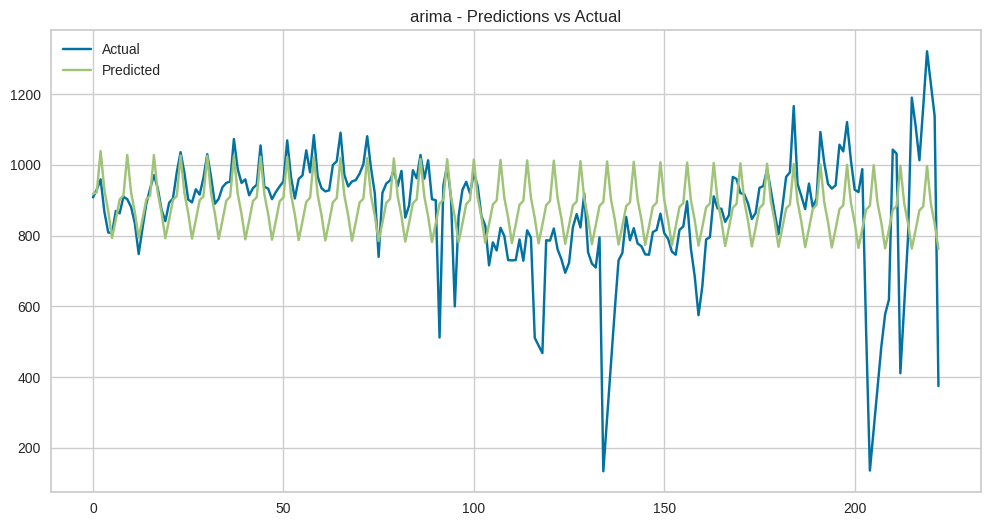

2026-01-02 23:43:36,128 - __main__ - INFO - Training and evaluating prophet...
2026-01-02 23:43:36,131 - models.model - INFO - Entrenando Prophet
2026-01-02 23:43:36,158 - cmdstanpy - INFO - Chain [1] start processing
2026-01-02 23:43:36,189 - cmdstanpy - INFO - Chain [1] done processing
2026-01-02 23:43:36,192 - models.model - INFO - Prophet entrenado exitosamente
2026-01-02 23:43:36,247 - __main__ - INFO - prophet - MAE: 276.2197, MSE: 109211.9003, R²: -2.6879


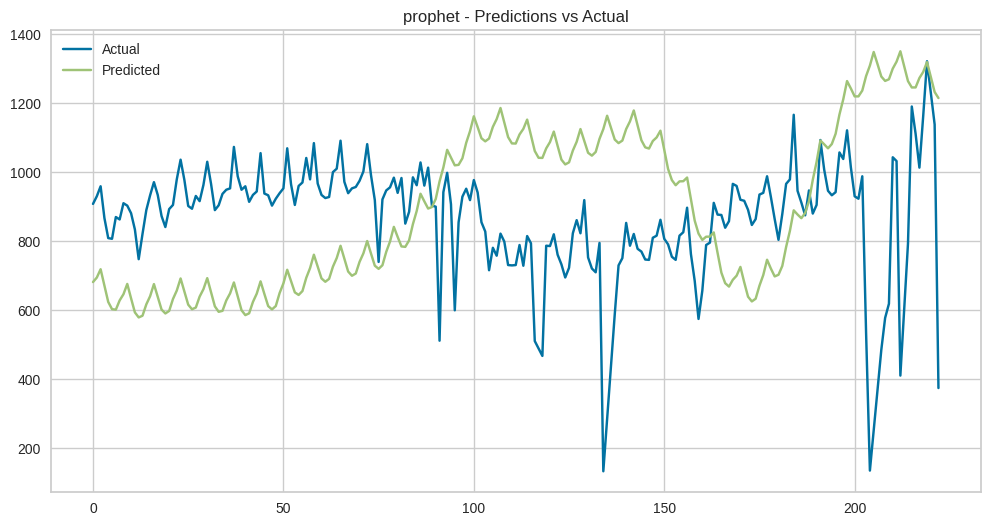

2026-01-02 23:43:36,362 - __main__ - INFO - Training and evaluating random_forest...
2026-01-02 23:43:36,362 - models.model - INFO - Entrenando Random Forest con 100 árboles
2026-01-02 23:43:37,286 - models.model - INFO - Random Forest entrenado exitosamente
2026-01-02 23:43:37,299 - __main__ - INFO - random_forest - MAE: 89.0341, MSE: 20463.7838, R²: 0.3090


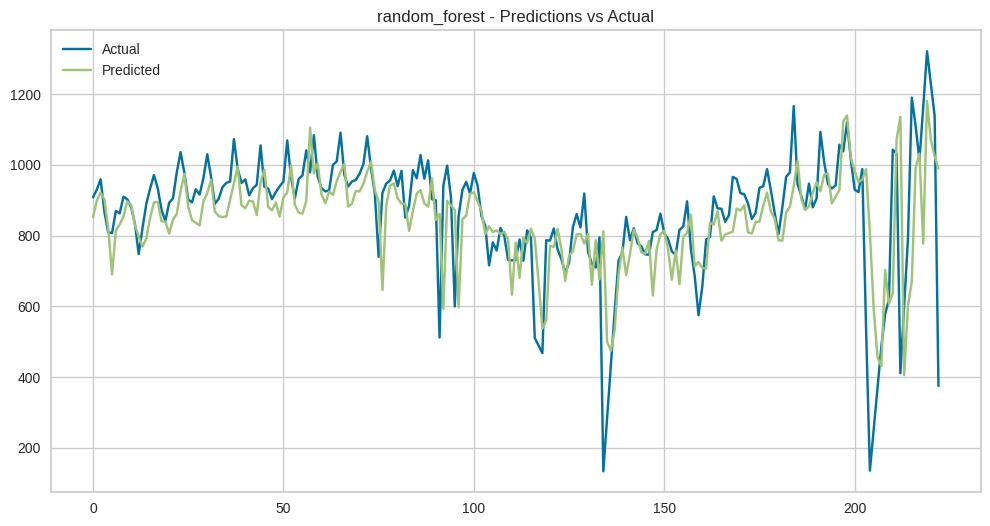

In [36]:
# 1. First, prepare your data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, shuffle=False  # Important: shuffle=False for time series
)

# 2. Create and train models
custom_models = {
    'arima': CustomARIMA(),
    'prophet': CustomProphet(),
    'random_forest': CustomRandomForest()
}

# 3. Train and evaluate each model
for name, model in custom_models.items():
    try:
        logger.info(f"Training and evaluating {name}...")
        # Make sure we're using the training data
        model.fit(X_train, y_train)
        
        # For prediction, we need to ensure the test data has the right format
        X_test_copy = X_test.copy()
        if name == 'prophet' and 'date' in X_test_copy.columns:
            X_test_copy = X_test_copy.rename(columns={'date': 'ds'})
            
        preds = model.predict(X_test_copy)
        
        # Calculate metrics
        mae = mean_absolute_error(y_test, preds)
        mse = mean_squared_error(y_test, preds)
        r2 = r2_score(y_test, preds)
        
        logger.info(f"{name} - MAE: {mae:.4f}, MSE: {mse:.4f}, R²: {r2:.4f}")
        
        # Plot predictions vs actual
        plt.figure(figsize=(12, 6))
        plt.plot(y_test.values, label='Actual')
        plt.plot(preds, label='Predicted')
        plt.title(f'{name} - Predictions vs Actual')
        plt.legend()
        plt.show()
        
    except Exception as e:
        logger.error(f"Error with {name}: {str(e)}")
        import traceback
        logger.error(traceback.format_exc())

In [37]:
# 10. Create and Tune Best Model
# ------------------------------
tuned_model = tune_model(CustomRandomForest(), optimize='MAE')

,,
,,
Initiated,. . . . . . . . . . . . . . . . . .,23:45:10
Status,. . . . . . . . . . . . . . . . . .,Loading Dependencies
Estimator,. . . . . . . . . . . . . . . . . .,Compiling Library


Processing:   0%|          | 0/7 [00:00<?, ?it/s]

ValueError: When passing a model not in PyCaret's model library, the custom_grid parameter must be provided.

In [44]:
# 10. Create and Tune Best Model with PyCaret
# ------------------------------------------

# First, let's create a custom model class that PyCaret can work with
from sklearn.base import BaseEstimator, RegressorMixin
from pycaret.regression import create_custom_model

# Define a simple wrapper class
class PyCaretRandomForestWrapper(RandomForestModel, BaseEstimator, RegressorMixin):
    def __init__(self, n_estimators=100, max_depth=None, min_samples_split=2, **kwargs):
        super().__init__(config)
        self.n_estimators = n_estimators
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self._fitted = False
    
    def fit(self, X, y, **fit_params):
        # Initialize the model with parameters
        self.model = RandomForestModel(config)
        self.model.model.set_params(
            n_estimators=self.n_estimators,
            max_depth=self.max_depth,
            min_samples_split=self.min_samples_split
        )
        self.model.fit(X, y)
        self._fitted = True
        return self
    
    def predict(self, X):
        if not self._fitted:
            raise Exception("Model not fitted yet")
        return self.model.predict(X)

# Create a custom model in PyCaret
custom_rf = create_custom_model(
    'rf_custom',
    class_def=PyCaretRandomForestWrapper,
    name='Custom Random Forest',
    description='Custom Random Forest for time series',
    tune_grid={
        'n_estimators': [50, 100, 200],
        'max_depth': [None, 10, 20, 30],
        'min_samples_split': [2, 5, 10]
    }
)

# Now you can use this model with PyCaret's functions
tuned_model = tune_model(
    custom_rf,
    optimize='MAE',
    n_iter=10,
    choose_better=True,
    verbose=True
)

ImportError: cannot import name 'create_custom_model' from 'pycaret.regression' (/home/gabo/Personal/Universidad/04 - Cuarto Año/1er Semestre/Machine Learning/Proyectos/ml-project/.venv/lib/python3.11/site-packages/pycaret/regression/__init__.py)

In [ ]:
# 12. Make Predictions
# --------------------
predictions = predict_model(final_model, data=X)
print(predictions.head())


In [ ]:
# 13. Analyze Model
# -----------------
plot_model(final_model, plot='error')
plot_model(final_model, plot='feature')
evaluate_model(final_model)

In [ ]:
# 14. Save Experiment
# -------------------
save_experiment('aircraft_forecasting_experiment')